In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [64]:
df = pd.read_csv('feature_dataframe.tsv', sep='\t') # Oslo-region
df = df.tail(8760)
df.reset_index(drop=True, inplace=True)
print(df.columns)
features = ['Actual Total Load [MW] - BZN|NO1','Lufttemperatur','Nedbør (1 t)','inflasjon']
df.replace(',', '.', regex=True, inplace=True)
df.head()
df = df[features].astype('float32')

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns).astype('float32')
print(df.head())
normalized_df.head()
len(df)

Index(['Lufttemperatur', 'Nedbør (1 t)', 'Actual Total Load [MW] - BZN|NO1',
       'inflasjon'],
      dtype='object')
   Actual Total Load [MW] - BZN|NO1  Lufttemperatur  Nedbør (1 t)  inflasjon
0                            4779.0            -3.0           0.0        3.2
1                            4701.0            -2.4           0.0        3.7
2                            4681.0            -1.9           0.0        3.7
3                            4620.0            -1.8           0.0        3.7
4                            4645.0            -2.1           0.0        3.7


8760

In [24]:
lookback= 6
def df_to_X_y(df, lookback=6):
    df_as_np = df.copy().to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-lookback):
        row = [r for r in df_as_np[i:i+lookback]]
        X.append(row)
        label = df_as_np[i+lookback][0]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(normalized_df,lookback)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=12)

In [4]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df

def metrics(model,X,y):
    predictions = model.predict(X).flatten()
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    return mse, r2

In [5]:
model = Sequential()
model.add(InputLayer((6, 4)))
model.add(LSTM(50))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, epochs=10, callbacks=[cp1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 11417 (44.60 KB)
Trainable params: 11417 (44.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 0.1222 - root_mean_squared_error: 0.3496
Epoch 2/10
219/219 [==============================] - 1s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1583
Epoch 3/10
219/219 [==============================] - 

219/219 [==============================] - 0s 1ms/step


,Predictions,Actuals
0,0.326467,0.384367
1,-0.425387,-0.428931
2,-0.225882,-0.290207
3,0.519215,0.508356
4,-0.441793,-0.433603
...,...,...
6998,0.409676,0.398023
6999,-0.663684,-0.662534
7000,-0.251250,-0.302066
7001,-0.422848,-0.388320


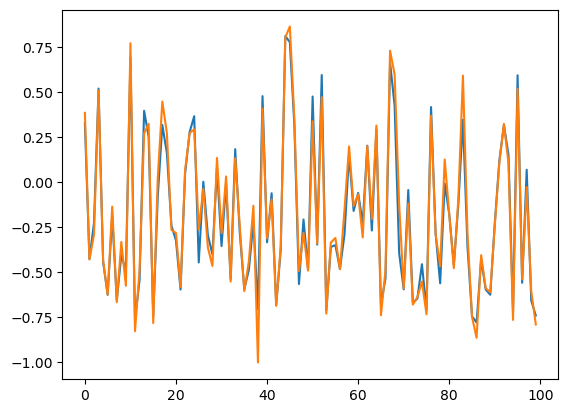

In [6]:
plot_predictions(model,X_train,y_train)

# Cecking learning rate and epochs

In [7]:
etas = np.logspace(-6,-1,10)
niterations = range(10,50,5)

mse_train_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
mse_test_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
r2_train_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
r2_test_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)

for i,eta in enumerate(etas):
    for j,epochs in enumerate(niterations):
        model = Sequential()
        model.add(InputLayer((6, 4)))
        model.add(LSTM(50))
        model.add(Dense(1, 'linear'))
        
        model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=eta), metrics=[RootMeanSquaredError()])
        model.fit(X_train, y_train, epochs=epochs)
        
        mse_train,r2_train = metrics(model,X_train,y_train)
        mse_test,r2_test = metrics(model,X_test,y_test)
        
        
        mse_train_list[i,j] =mse_train
        mse_test_list[i,j] = mse_test
        r2_train_list[i,j] = r2_train
        r2_test_list[i,j] = r2_test

Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 0.3104 - root_mean_squared_error: 0.5572
Epoch 2/10
219/219 [==============================] - 1s 2ms/step - loss: 0.3015 - root_mean_squared_error: 0.5491
Epoch 3/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2928 - root_mean_squared_error: 0.5411
Epoch 4/10
219/219 [==============================] - 1s 3ms/step - loss: 0.2843 - root_mean_squared_error: 0.5332
Epoch 5/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2760 - root_mean_squared_error: 0.5254
Epoch 6/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2680 - root_mean_squared_error: 0.5177
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2601 - root_mean_squared_error: 0.5100
Epoch 8/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2525 - root_mean_squared_error: 0.5025
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 0.2450

219/219 [==============================] - 0s 2ms/step - loss: 0.1043 - root_mean_squared_error: 0.3230
Epoch 25/25
55/55 [==============================] - 0s 1ms/step
Epoch 1/30
219/219 [==============================] - 2s 2ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461
Epoch 2/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
Epoch 3/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
Epoch 4/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1850 - root_mean_squared_error: 0.4301
Epoch 5/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1806 - root_mean_squared_error: 0.4250
Epoch 6/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1763 - root_mean_squared_error: 0.4199
Epoch 7/30
219/219 [==============================] - 0s 2ms/step - loss: 0.1722 - root_mean_squared_error: 0.4149
Epoch 8/30
219/219 [======

219/219 [==============================] - 0s 2ms/step - loss: 0.1388 - root_mean_squared_error: 0.3725
Epoch 3/40
219/219 [==============================] - 0s 2ms/step - loss: 0.1329 - root_mean_squared_error: 0.3646
Epoch 4/40
219/219 [==============================] - 0s 2ms/step - loss: 0.1273 - root_mean_squared_error: 0.3568
Epoch 5/40
219/219 [==============================] - 0s 2ms/step - loss: 0.1219 - root_mean_squared_error: 0.3492
Epoch 6/40
219/219 [==============================] - 1s 2ms/step - loss: 0.1168 - root_mean_squared_error: 0.3418
Epoch 7/40
219/219 [==============================] - 1s 2ms/step - loss: 0.1119 - root_mean_squared_error: 0.3345
Epoch 8/40
219/219 [==============================] - 1s 2ms/step - loss: 0.1071 - root_mean_squared_error: 0.3273
Epoch 9/40
219/219 [==============================] - 1s 2ms/step - loss: 0.1026 - root_mean_squared_error: 0.3203
Epoch 10/40
219/219 [==============================] - 1s 2ms/step - loss: 0.0982 - root_me

219/219 [==============================] - 1s 2ms/step - loss: 0.0522 - root_mean_squared_error: 0.2284
Epoch 32/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255
Epoch 33/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226
Epoch 34/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0483 - root_mean_squared_error: 0.2197
Epoch 35/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0470 - root_mean_squared_error: 0.2168
Epoch 36/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140
Epoch 37/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0446 - root_mean_squared_error: 0.2112
Epoch 38/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084
Epoch 39/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0423 - 

219/219 [==============================] - 0s 2ms/step - loss: 0.1534 - root_mean_squared_error: 0.3917
Epoch 9/25
219/219 [==============================] - 0s 2ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727
Epoch 10/25
219/219 [==============================] - 0s 2ms/step - loss: 0.1259 - root_mean_squared_error: 0.3548
Epoch 11/25
219/219 [==============================] - 0s 2ms/step - loss: 0.1143 - root_mean_squared_error: 0.3381
Epoch 12/25
219/219 [==============================] - 0s 2ms/step - loss: 0.1039 - root_mean_squared_error: 0.3223
Epoch 13/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0946 - root_mean_squared_error: 0.3076
Epoch 14/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0863 - root_mean_squared_error: 0.2938
Epoch 15/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0789 - root_mean_squared_error: 0.2809
Epoch 16/25
219/219 [==============================] - 1s 2ms/step - loss: 0.0723 - r

219/219 [==============================] - 1s 2ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647
Epoch 23/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592
Epoch 24/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543
Epoch 25/35
219/219 [==============================] - 1s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1498
Epoch 26/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459
Epoch 27/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424
Epoch 28/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393
Epoch 29/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365
Epoch 30/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0180 - 

219/219 [==============================] - 0s 2ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926
Epoch 17/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0782 - root_mean_squared_error: 0.2796
Epoch 18/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0713 - root_mean_squared_error: 0.2671
Epoch 19/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550
Epoch 20/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0592 - root_mean_squared_error: 0.2433
Epoch 21/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322
Epoch 22/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216
Epoch 23/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0448 - root_mean_squared_error: 0.2117
Epoch 24/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0410 - 

219/219 [==============================] - 0s 2ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237
Epoch 15/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221
Epoch 16/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207
Epoch 17/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 18/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186
Epoch 19/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176
Epoch 20/20
55/55 [==============================] - 0s 1ms/step
Epoch 1/25
219/219 [==============================] - 2s 2ms/step - loss: 0.2526 - root_mean_squared_error: 0.5026
Epoch 2/25
219/219 [==============================] - 0s 2ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
Epoch 3/25
219/219 [=

219/219 [==============================] - 0s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571
Epoch 8/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405
Epoch 9/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315
Epoch 10/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268
Epoch 11/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241
Epoch 12/35
219/219 [==============================] - 1s 3ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
Epoch 13/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212
Epoch 14/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204
Epoch 15/35
219/219 [==============================] - 1s 3ms/step - loss: 0.0143 - ro

Epoch 1/45
219/219 [==============================] - 2s 2ms/step - loss: 0.0959 - root_mean_squared_error: 0.3097
Epoch 2/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0710 - root_mean_squared_error: 0.2664
Epoch 3/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359
Epoch 4/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0452 - root_mean_squared_error: 0.2126
Epoch 5/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944
Epoch 6/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0324 - root_mean_squared_error: 0.1801
Epoch 7/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0284 - root_mean_squared_error: 0.1685
Epoch 8/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592
Epoch 9/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0230

Epoch 15/15
55/55 [==============================] - 0s 1ms/step
Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1560 - root_mean_squared_error: 0.3949
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178
Epoch 9/20
219/

219/219 [==============================] - 0s 2ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907
Epoch 24/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873
Epoch 25/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839
Epoch 26/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807
Epoch 27/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775
Epoch 28/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748
Epoch 29/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 30/30
55/55 [==============================] - 0s 1ms/step
Epoch 1/35
219/219 [==============================] - 2s 2ms/step - loss: 0.1223 - root_mean_squared_error: 0.3497
Epoch 2/35
219/219 [

219/219 [==============================] - 0s 2ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675
Epoch 28/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662
Epoch 29/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651
Epoch 30/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641
Epoch 31/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633
Epoch 32/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624
Epoch 33/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 34/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608
Epoch 35/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0036 - 

55/55 [==============================] - 0s 1ms/step
Epoch 1/15
219/219 [==============================] - 2s 2ms/step - loss: 0.0748 - root_mean_squared_error: 0.2734
Epoch 2/15
219/219 [==============================] - 0s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314
Epoch 3/15
219/219 [==============================] - 0s 2ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
Epoch 4/15
219/219 [==============================] - 0s 2ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
Epoch 5/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105
Epoch 6/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040
Epoch 7/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963
Epoch 8/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882
Epoch 9/15
219/219 [=======

219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695
Epoch 9/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0042 - root_mean_squared_error: 0.0652
Epoch 10/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 11/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611
Epoch 12/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589
Epoch 13/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0569
Epoch 14/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554
Epoch 15/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533
Epoch 16/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0027 - r

219/219 [==============================] - 0s 2ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648
Epoch 13/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 14/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584
Epoch 15/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0567
Epoch 16/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553
Epoch 17/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532
Epoch 18/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522
Epoch 19/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500
Epoch 20/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0024 - 

219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331
Epoch 42/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326
Epoch 43/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327
Epoch 44/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328
Epoch 45/45
55/55 [==============================] - 0s 1ms/step
Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 0.0284 - root_mean_squared_error: 0.1685
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123
Epoch 3/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884
Epoch 4/10
219/219 [==============================] - 1s 2ms/step - loss: 0.0043 - root_mean_squared_error: 0.0660
Epoch 5/10
219/219 [===

219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333
Epoch 19/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333
Epoch 20/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322
Epoch 21/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324
Epoch 22/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322
Epoch 23/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327
Epoch 24/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322
Epoch 25/25
55/55 [==============================] - 0s 1ms/step
Epoch 1/30
219/219 [==============================] - 2s 2ms/step - loss: 0.0435 - root_mean_squared_error: 0.2087
Epoch 2/30
219/219 [

219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317
Epoch 32/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316
Epoch 33/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 34/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 35/35
55/55 [==============================] - 0s 1ms/step
Epoch 1/40
219/219 [==============================] - 2s 2ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791
Epoch 2/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120
Epoch 3/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914
Epoch 4/40
219/219 [==============================] - 0s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703
Epoch 5/40
219/219 [===

219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323
Epoch 25/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325
Epoch 26/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322
Epoch 27/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317
Epoch 28/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318
Epoch 29/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317
Epoch 30/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318
Epoch 31/45
219/219 [==============================] - 0s 2ms/step - loss: 9.8385e-04 - root_mean_squared_error: 0.0314
Epoch 32/45
219/219 [==============================] - 0s 2ms/step - loss: 9.839

55/55 [==============================] - 0s 1ms/step
Epoch 1/25
219/219 [==============================] - 2s 2ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081
Epoch 2/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530
Epoch 3/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408
Epoch 4/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361
Epoch 5/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 6/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333
Epoch 7/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330
Epoch 8/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328
Epoch 9/25
219/219 [=======

219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323
Epoch 14/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 15/35
219/219 [==============================] - 0s 2ms/step - loss: 9.7211e-04 - root_mean_squared_error: 0.0312
Epoch 16/35
219/219 [==============================] - 0s 2ms/step - loss: 9.7568e-04 - root_mean_squared_error: 0.0312
Epoch 17/35
219/219 [==============================] - 0s 2ms/step - loss: 9.6257e-04 - root_mean_squared_error: 0.0310
Epoch 18/35
219/219 [==============================] - 0s 2ms/step - loss: 9.4926e-04 - root_mean_squared_error: 0.0308
Epoch 19/35
219/219 [==============================] - 0s 2ms/step - loss: 9.5497e-04 - root_mean_squared_error: 0.0309
Epoch 20/35
219/219 [==============================] - 0s 2ms/step - loss: 9.2029e-04 - root_mean_squared_error: 0.0303
Epoch 21/35
219/219 [==============================] - 0s 2m

219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339
Epoch 6/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333
Epoch 7/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326
Epoch 8/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324
Epoch 9/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325
Epoch 10/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 11/45
219/219 [==============================] - 0s 2ms/step - loss: 9.9991e-04 - root_mean_squared_error: 0.0316
Epoch 12/45
219/219 [==============================] - 0s 2ms/step - loss: 9.9387e-04 - root_mean_squared_error: 0.0315
Epoch 13/45
219/219 [==============================] - 1s 2ms/step - loss: 9.726

219/219 [==============================] - 2s 2ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 9.8311e-04 - root_mean_squared_error: 0.0314
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 9.8463e-04 - 

219/219 [==============================] - 0s 2ms/step - loss: 8.1168e-04 - root_mean_squared_error: 0.0285
Epoch 24/30
219/219 [==============================] - 0s 2ms/step - loss: 7.9635e-04 - root_mean_squared_error: 0.0282
Epoch 25/30
219/219 [==============================] - 0s 2ms/step - loss: 8.0093e-04 - root_mean_squared_error: 0.0283
Epoch 26/30
219/219 [==============================] - 0s 2ms/step - loss: 8.1227e-04 - root_mean_squared_error: 0.0285
Epoch 27/30
219/219 [==============================] - 0s 2ms/step - loss: 7.9499e-04 - root_mean_squared_error: 0.0282
Epoch 28/30
219/219 [==============================] - 0s 2ms/step - loss: 7.8321e-04 - root_mean_squared_error: 0.0280
Epoch 29/30
219/219 [==============================] - 0s 2ms/step - loss: 7.4632e-04 - root_mean_squared_error: 0.0273
Epoch 30/30
55/55 [==============================] - 0s 1ms/step
Epoch 1/35
219/219 [==============================] - 2s 2ms/step - loss: 0.0092 - root_mean_squared_error:

219/219 [==============================] - 0s 2ms/step - loss: 7.5892e-04 - root_mean_squared_error: 0.0275
Epoch 26/40
219/219 [==============================] - 0s 2ms/step - loss: 7.2546e-04 - root_mean_squared_error: 0.0269
Epoch 27/40
219/219 [==============================] - 0s 2ms/step - loss: 7.3215e-04 - root_mean_squared_error: 0.0271
Epoch 28/40
219/219 [==============================] - 0s 2ms/step - loss: 7.3184e-04 - root_mean_squared_error: 0.0271
Epoch 29/40
219/219 [==============================] - 0s 2ms/step - loss: 7.2712e-04 - root_mean_squared_error: 0.0270
Epoch 30/40
219/219 [==============================] - 0s 2ms/step - loss: 7.3194e-04 - root_mean_squared_error: 0.0271
Epoch 31/40
219/219 [==============================] - 0s 2ms/step - loss: 6.9877e-04 - root_mean_squared_error: 0.0264
Epoch 32/40
219/219 [==============================] - 0s 2ms/step - loss: 6.9128e-04 - root_mean_squared_error: 0.0263
Epoch 33/40
219/219 [==============================]

219/219 [==============================] - 0s 2ms/step - loss: 9.8748e-04 - root_mean_squared_error: 0.0314
Epoch 8/10
219/219 [==============================] - 0s 2ms/step - loss: 9.6589e-04 - root_mean_squared_error: 0.0311
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 9.5789e-04 - root_mean_squared_error: 0.0309
Epoch 10/10
55/55 [==============================] - 0s 1ms/step
Epoch 1/15
219/219 [==============================] - 2s 2ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156
Epoch 2/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347
Epoch 3/15
219/219 [==============================] - 1s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336
Epoch 4/15
219/219 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 5/15
219/219 [==============================] - 0s 2ms/step - loss: 9.8388e-04 - root_mean_squared_error: 0.0314
Epoch 6/15

219/219 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
Epoch 3/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Epoch 4/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332
Epoch 5/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317
Epoch 6/30
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 7/30
219/219 [==============================] - 0s 2ms/step - loss: 9.4146e-04 - root_mean_squared_error: 0.0307
Epoch 8/30
219/219 [==============================] - 0s 2ms/step - loss: 9.3689e-04 - root_mean_squared_error: 0.0306
Epoch 9/30
219/219 [==============================] - 0s 2ms/step - loss: 9.4446e-04 - root_mean_squared_error: 0.0307
Epoch 10/30
219/219 [==============================] - 0s 2ms/step - loss: 9.15

219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332
Epoch 5/40
219/219 [==============================] - 0s 2ms/step - loss: 9.8586e-04 - root_mean_squared_error: 0.0314
Epoch 6/40
219/219 [==============================] - 0s 2ms/step - loss: 9.5335e-04 - root_mean_squared_error: 0.0309
Epoch 7/40
219/219 [==============================] - 0s 2ms/step - loss: 9.4073e-04 - root_mean_squared_error: 0.0307
Epoch 8/40
219/219 [==============================] - 0s 2ms/step - loss: 9.1441e-04 - root_mean_squared_error: 0.0302
Epoch 9/40
219/219 [==============================] - 0s 2ms/step - loss: 9.0723e-04 - root_mean_squared_error: 0.0301
Epoch 10/40
219/219 [==============================] - 0s 2ms/step - loss: 8.6721e-04 - root_mean_squared_error: 0.0294
Epoch 11/40
219/219 [==============================] - 0s 2ms/step - loss: 9.7207e-04 - root_mean_squared_error: 0.0312
Epoch 12/40
219/219 [==============================] - 0s 2ms

219/219 [==============================] - 0s 2ms/step - loss: 9.0518e-04 - root_mean_squared_error: 0.0301
Epoch 32/45
219/219 [==============================] - 0s 2ms/step - loss: 7.6002e-04 - root_mean_squared_error: 0.0276
Epoch 33/45
219/219 [==============================] - 0s 2ms/step - loss: 7.8952e-04 - root_mean_squared_error: 0.0281
Epoch 34/45
219/219 [==============================] - 0s 2ms/step - loss: 8.3821e-04 - root_mean_squared_error: 0.0290
Epoch 35/45
219/219 [==============================] - 0s 2ms/step - loss: 7.6750e-04 - root_mean_squared_error: 0.0277
Epoch 36/45
219/219 [==============================] - 0s 2ms/step - loss: 7.8594e-04 - root_mean_squared_error: 0.0280
Epoch 37/45
219/219 [==============================] - 0s 2ms/step - loss: 8.5029e-04 - root_mean_squared_error: 0.0292
Epoch 38/45
219/219 [==============================] - 0s 2ms/step - loss: 7.9297e-04 - root_mean_squared_error: 0.0282
Epoch 39/45
219/219 [==============================]

219/219 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345
Epoch 8/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327
Epoch 9/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337
Epoch 10/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 11/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321
Epoch 12/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336
Epoch 13/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339
Epoch 14/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 15/25
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - ro

219/219 [==============================] - 0s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373
Epoch 21/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 22/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331
Epoch 23/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 24/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335
Epoch 25/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332
Epoch 26/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 27/35
219/219 [==============================] - 1s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 28/35
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - 

219/219 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319
Epoch 14/45
219/219 [==============================] - 0s 2ms/step - loss: 9.2036e-04 - root_mean_squared_error: 0.0303
Epoch 15/45
219/219 [==============================] - 1s 3ms/step - loss: 9.2676e-04 - root_mean_squared_error: 0.0304
Epoch 16/45
219/219 [==============================] - 1s 2ms/step - loss: 9.8985e-04 - root_mean_squared_error: 0.0315
Epoch 17/45
219/219 [==============================] - 1s 2ms/step - loss: 9.8067e-04 - root_mean_squared_error: 0.0313
Epoch 18/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332
Epoch 19/45
219/219 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321
Epoch 20/45
219/219 [==============================] - 0s 2ms/step - loss: 9.1556e-04 - root_mean_squared_error: 0.0303
Epoch 21/45
219/219 [==============================] - 1s 2ms/st

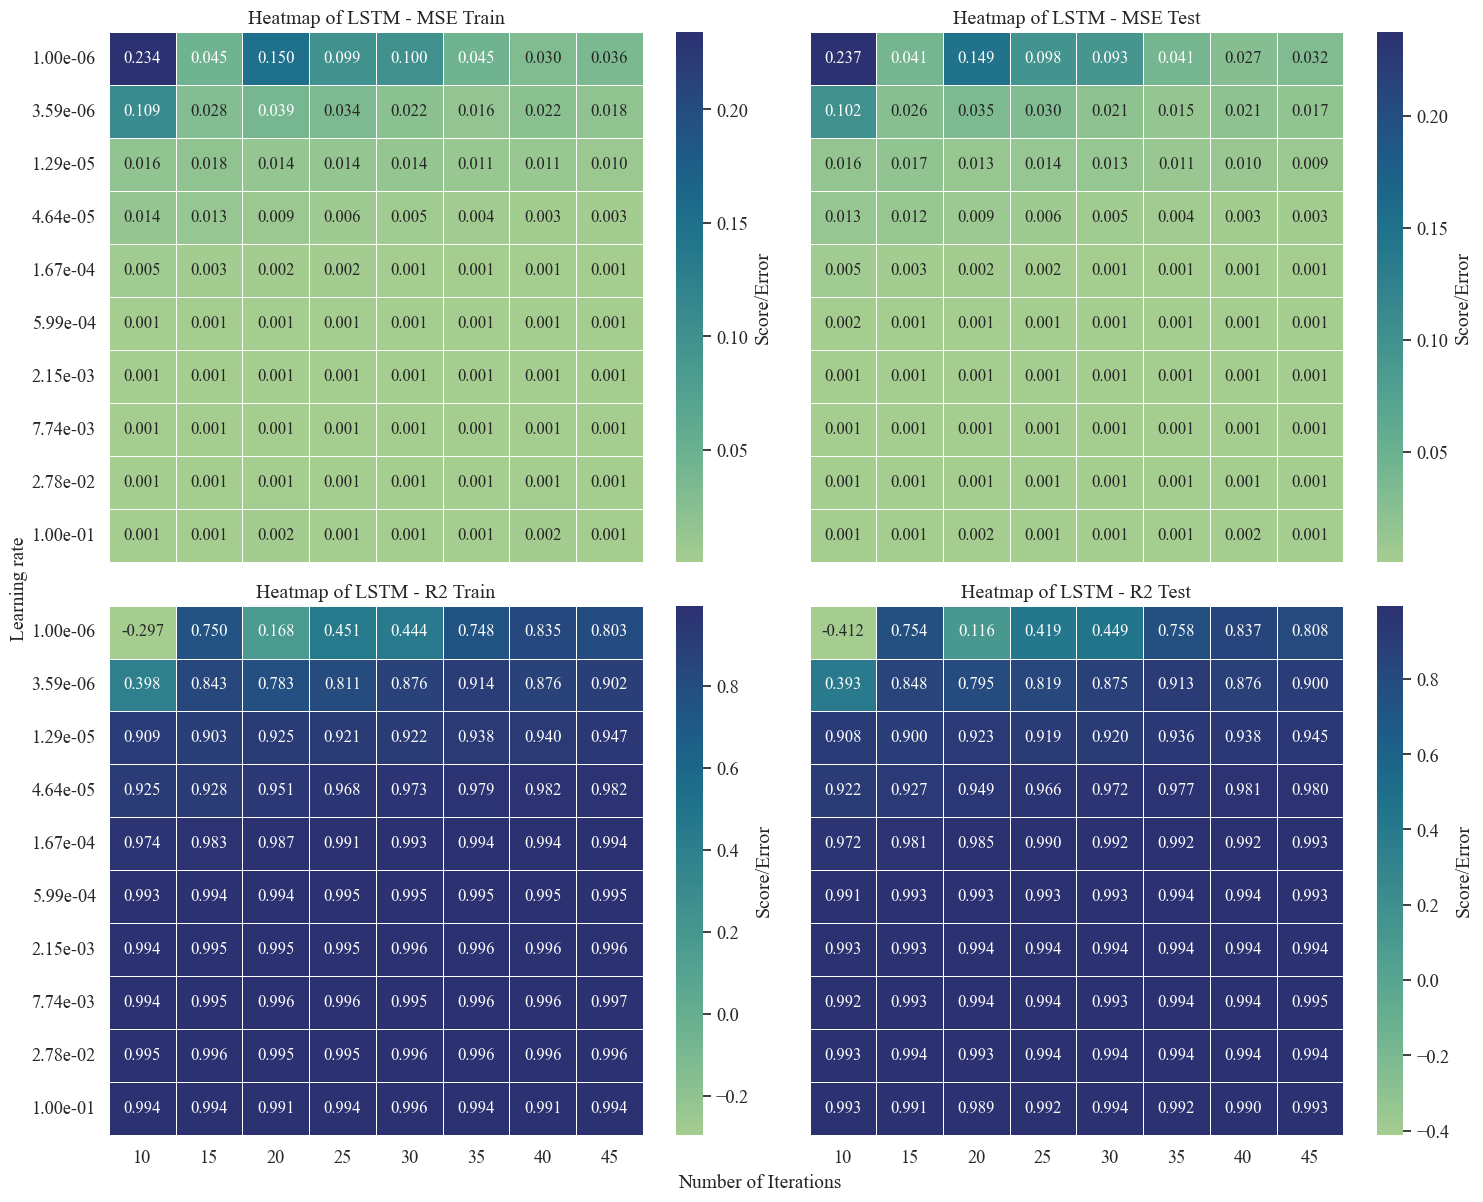

In [8]:
formatted_etas = ['{:.2e}'.format(i) for i in etas]
df_mse_train=pd.DataFrame(mse_train_list,index = formatted_etas ,columns=niterations)
df_mse_test=pd.DataFrame(mse_test_list,index = formatted_etas ,columns=niterations)
df_r2_train=pd.DataFrame(r2_train_list,index = formatted_etas ,columns=niterations)
df_r2_test=pd.DataFrame(r2_test_list,index = formatted_etas ,columns=niterations)

sns.set(font='Times New Roman', style='whitegrid', font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Plot each heatmap on a subplot
heatmaps = [(df_mse_train, 'MSE Train'), (df_mse_test, 'MSE Test'), (df_r2_train, 'R2 Train'), (df_r2_test, 'R2 Test')]
for (df, title), ax in zip(heatmaps, axes.flatten()):
    sns.heatmap(df, 
                annot=True, 
                cmap="crest", 
                fmt=".3f", 
                linewidths=0.5, 
                annot_kws={"size": 12}, 
                cbar_kws={'label': 'Score/Error'}, 
                ax=ax)
    ax.set_title(f'Heatmap of LSTM - {title}')

# Set common labels
fig.text(0.5, 0.00, 'Number of Iterations', ha='center', fontsize=14)
fig.text(0.00, 0.5, 'Learning rate', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

# CHecking for different lookbacks

Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709
Epoch 3/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710
Epoch 4/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610
Epoch 5/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630
Epoch 6/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655
Epoch 7/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 8/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648
Epoch 9/10
219/219 [==============================] - 0s 2ms/step - loss: 0.0046

219/219 [==============================] - 1s 6ms/step - loss: 0.1617 - root_mean_squared_error: 0.4021
Epoch 6/10
219/219 [==============================] - 1s 6ms/step - loss: 0.1255 - root_mean_squared_error: 0.3542
Epoch 7/10
219/219 [==============================] - 1s 6ms/step - loss: 0.1043 - root_mean_squared_error: 0.3230
Epoch 8/10
219/219 [==============================] - 1s 6ms/step - loss: 0.0906 - root_mean_squared_error: 0.3010
Epoch 9/10
219/219 [==============================] - 1s 6ms/step - loss: 0.0777 - root_mean_squared_error: 0.2788
Epoch 10/10
55/55 [==============================] - 0s 3ms/step
Epoch 1/10
219/219 [==============================] - 3s 8ms/step - loss: 963786.5000 - root_mean_squared_error: 981.7263
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 70.9417 - root_mean_squared_error: 8.4227
Epoch 3/10
219/219 [==============================] - 2s 7ms/step - loss: 0.0882 - root_mean_squared_error: 0.2970
Epoch 4/10
219/219

,Predictions,Actuals
0,-4.197673,0.320395
1,-0.028977,-0.652830
2,1.050159,0.066307
3,1.089481,0.508356
4,-0.247281,-0.680503
...,...,...
6995,-7.319855,0.181671
6996,-0.626563,-0.733333
6997,0.862552,-0.396226
6998,-0.120376,-0.415993


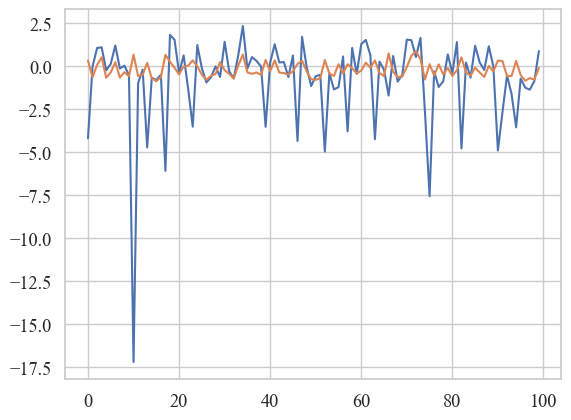

In [79]:
eta = 0.1
epochs = 10
lookbacks = range(1,10)

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []

for i,lb in enumerate(lookbacks):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lb, 4)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(2, 'linear'))
        
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=eta), metrics=[RootMeanSquaredError()])
        
    X, y = df_to_X_y(normalized_df,lb)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=12)
    model.fit(X_train, y_train, epochs=epochs)
        
    mse_train,r2_train = metrics(model,X_train,y_train)
    mse_test,r2_test = metrics(model,X_test,y_test)
        
        
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
plot_predictions(model,X_train,y_train)

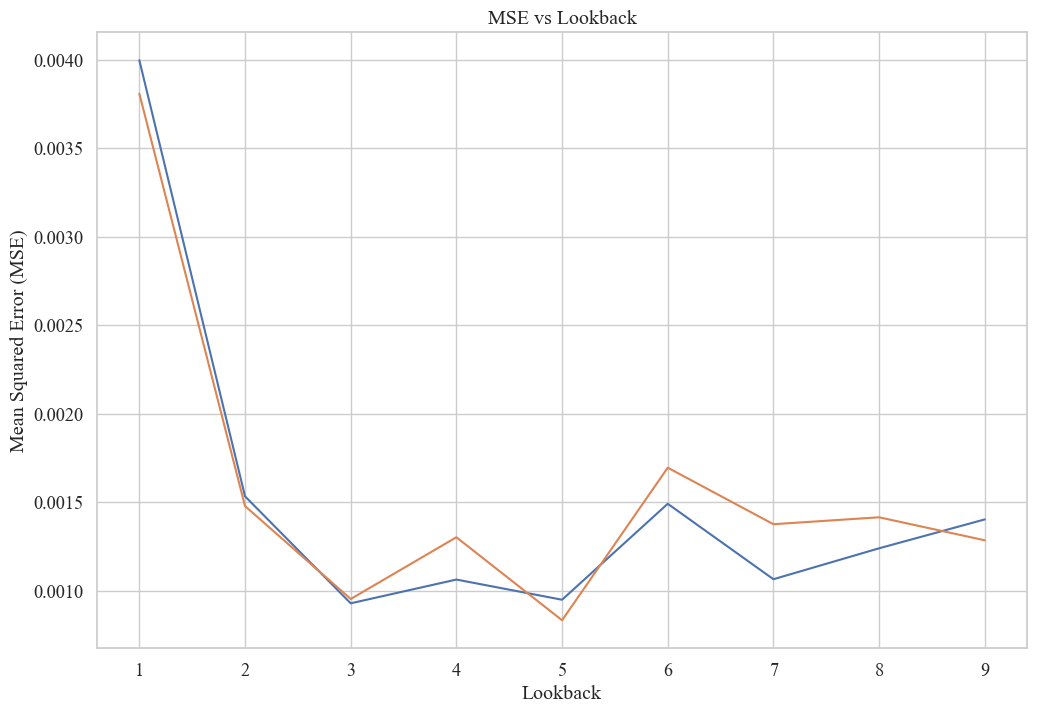

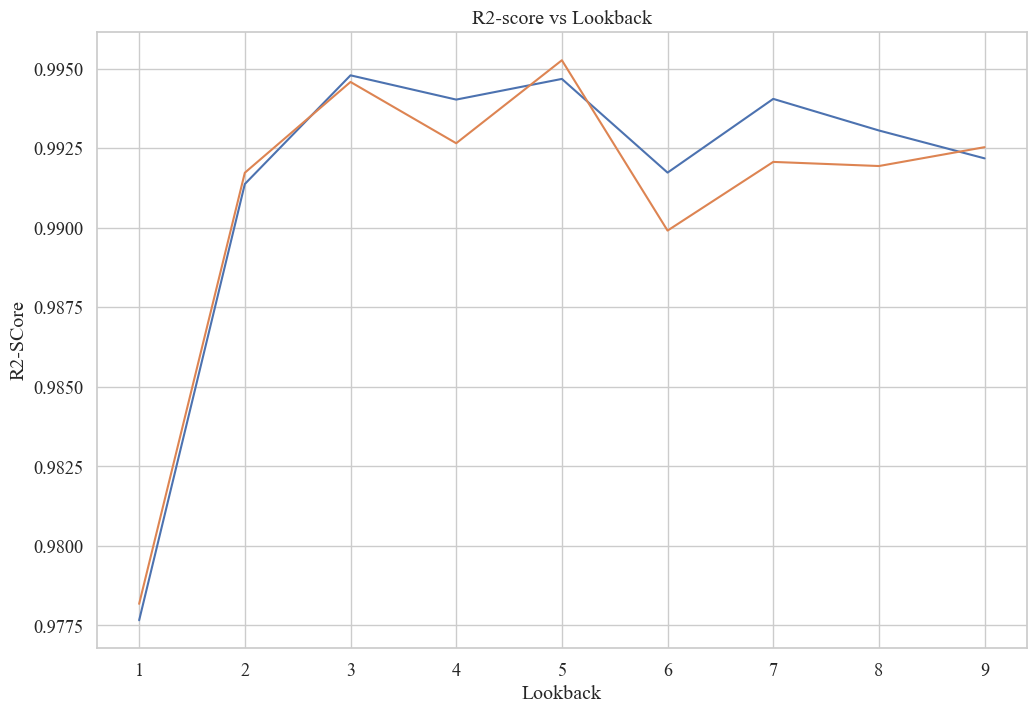

In [77]:
fig = plt.figure(figsize=(12, 8))
plt.plot(lookbacks, mse_train_list)
plt.plot(lookbacks,mse_test_list)
plt.xlabel('Lookback')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Lookback')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(lookbacks, r2_train_list)
plt.plot(lookbacks,r2_test_list)
plt.xlabel('Lookback')
plt.ylabel('R2-SCore')
plt.title('R2-score vs Lookback')
plt.show()

# checking for differet offsets (tensor flow)

In [25]:

#column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
df.head()
#train_df.head()

,Actual Total Load [MW] - BZN|NO1,Lufttemperatur,Nedbør (1 t),inflasjon
0,4779.0,-3.0,0.0,3.2
1,4701.0,-2.4,0.0,3.7
2,4681.0,-1.9,0.0,3.7
3,4620.0,-1.8,0.0,3.7
4,4645.0,-2.1,0.0,3.7


In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [41]:
def compile_and_fit(model, window, patience=2,eta = 0.001, epochs =10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = eta),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


In [42]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df = train_df,val_df = val_df, test_df = test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='Actual Total Load [MW] - BZN|NO1', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example
    WindowGenerator.make_dataset = make_dataset
    WindowGenerator.split_window = split_window
    WindowGenerator.plot = plot

In [43]:
features = 4
inputs = 24
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=inputs,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [55]:
import IPython
import IPython.display

epochs = 200
etas = np.logspace(-6,-1,10) 
eta = 0.01

54/54 [==============================] - 0s 2ms/step - loss: 0.2886 - mean_absolute_error: 0.2561


[0.5602870583534241, 0.5136712789535522]

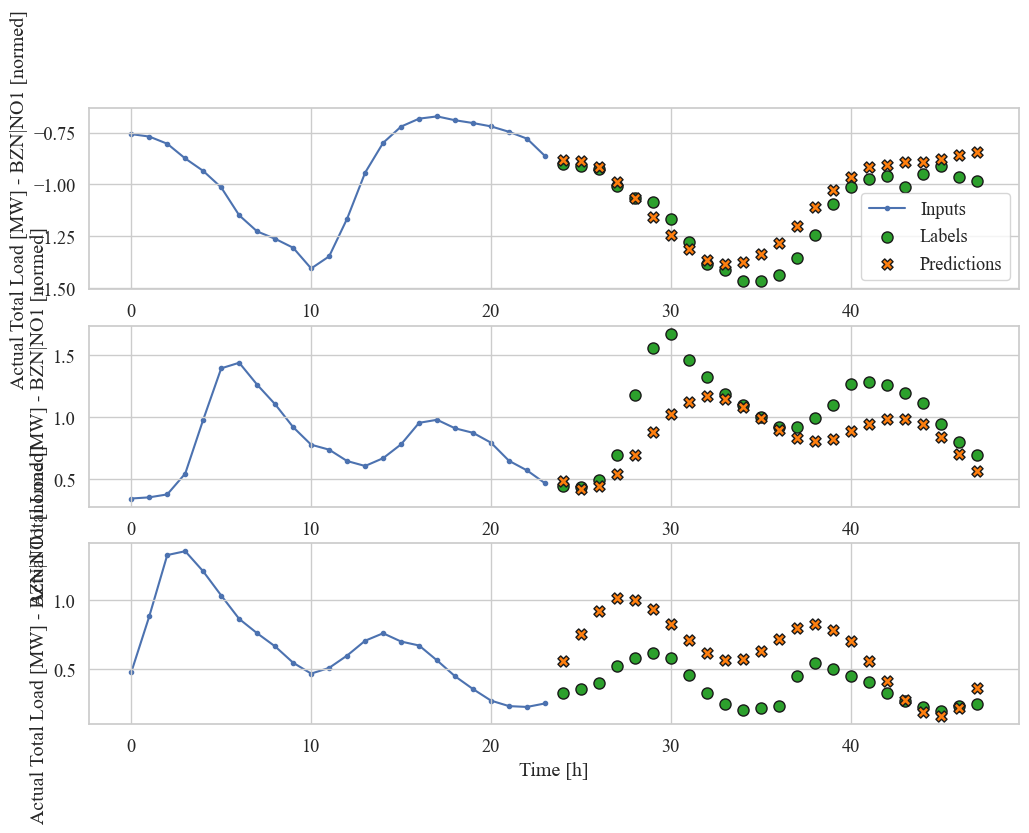

In [56]:
 multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_lstm_model, multi_window,eta = eta,epochs = epochs)
print(history)
multi_val_performance = {}
multi_performance = {}
IPython.display.clear_output()


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
multi_performance['LSTM']

In [59]:
etas = np.logspace(-6,-1,10) 
niterations = range(10,50,5)

mse_train_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
mse_test_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
r2_train_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)
r2_test_list = np.zeros((len(etas), len(niterations)),dtype=np.float32)

multi_val_performance = {}
multi_performance = {}

for i,eta in enumerate(etas):
    for j,epochs in enumerate(niterations):
        multi_lstm_model = tf.keras.Sequential([
            tf.keras.layers.LSTM(32, return_sequences=False),
            tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

        history = compile_and_fit(multi_lstm_model, multi_window,eta = eta,epochs = epochs)
        
        multi_val_performance[i,j] = multi_lstm_model.evaluate(multi_window.val)
        multi_performance[i,j] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
        
        
        #mse_train,r2_train = metrics(multi_lstm_model,X_train,y_train)
        #mse_test,r2_test = metrics(multi_lstm_model,X_test,y_test)


        #mse_train_list[i,j] =mse_train
       # mse_test_list[i,j] = mse_test
        #r2_train_list[i,j] = r2_train
        #r2_test_list[i,j] = r2_test

Epoch 1/10
191/191 [==============================] - 2s 6ms/step - loss: 0.9863 - mean_absolute_error: 0.7124 - val_loss: 0.5440 - val_mean_absolute_error: 0.4704
Epoch 2/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9850 - mean_absolute_error: 0.7118 - val_loss: 0.5437 - val_mean_absolute_error: 0.4703
Epoch 3/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9837 - mean_absolute_error: 0.7112 - val_loss: 0.5434 - val_mean_absolute_error: 0.4701
Epoch 4/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9824 - mean_absolute_error: 0.7105 - val_loss: 0.5430 - val_mean_absolute_error: 0.4699
Epoch 5/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9810 - mean_absolute_error: 0.7098 - val_loss: 0.5427 - val_mean_absolute_error: 0.4698
Epoch 6/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9796 - mean_absolute_error: 0.7091 - val_loss: 0.5423 - val_mean_absolute_error: 0.4696
Epoch 7/10
191/1

191/191 [==============================] - 1s 5ms/step - loss: 0.9829 - mean_absolute_error: 0.7108 - val_loss: 0.5432 - val_mean_absolute_error: 0.4700
Epoch 5/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9816 - mean_absolute_error: 0.7102 - val_loss: 0.5429 - val_mean_absolute_error: 0.4698
Epoch 6/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9804 - mean_absolute_error: 0.7096 - val_loss: 0.5426 - val_mean_absolute_error: 0.4697
Epoch 7/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9790 - mean_absolute_error: 0.7090 - val_loss: 0.5423 - val_mean_absolute_error: 0.4695
Epoch 8/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9777 - mean_absolute_error: 0.7083 - val_loss: 0.5419 - val_mean_absolute_error: 0.4694
Epoch 9/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9763 - mean_absolute_error: 0.7076 - val_loss: 0.5416 - val_mean_absolute_error: 0.4692
Epoch 10/25
191/191 [======

191/191 [==============================] - 1s 5ms/step - loss: 0.9428 - mean_absolute_error: 0.6911 - val_loss: 0.5314 - val_mean_absolute_error: 0.4638
Epoch 29/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9408 - mean_absolute_error: 0.6901 - val_loss: 0.5308 - val_mean_absolute_error: 0.4635
Epoch 30/30
54/54 [==============================] - 0s 2ms/step - loss: 0.5303 - mean_absolute_error: 0.4632
Epoch 1/35
191/191 [==============================] - 2s 6ms/step - loss: 0.9864 - mean_absolute_error: 0.7125 - val_loss: 0.5441 - val_mean_absolute_error: 0.4704
Epoch 2/35
191/191 [==============================] - 1s 5ms/step - loss: 0.9852 - mean_absolute_error: 0.7119 - val_loss: 0.5438 - val_mean_absolute_error: 0.4703
Epoch 3/35
191/191 [==============================] - 1s 5ms/step - loss: 0.9841 - mean_absolute_error: 0.7114 - val_loss: 0.5435 - val_mean_absolute_error: 0.4701
Epoch 4/35
191/191 [==============================] - 1s 5ms/step - loss: 0.9829

191/191 [==============================] - 1s 5ms/step - loss: 0.9766 - mean_absolute_error: 0.7077 - val_loss: 0.5408 - val_mean_absolute_error: 0.4686
Epoch 12/40
191/191 [==============================] - 1s 5ms/step - loss: 0.9755 - mean_absolute_error: 0.7072 - val_loss: 0.5404 - val_mean_absolute_error: 0.4684
Epoch 13/40
191/191 [==============================] - 1s 5ms/step - loss: 0.9743 - mean_absolute_error: 0.7066 - val_loss: 0.5400 - val_mean_absolute_error: 0.4682
Epoch 14/40
191/191 [==============================] - 1s 5ms/step - loss: 0.9731 - mean_absolute_error: 0.7060 - val_loss: 0.5396 - val_mean_absolute_error: 0.4680
Epoch 15/40
191/191 [==============================] - 1s 5ms/step - loss: 0.9718 - mean_absolute_error: 0.7054 - val_loss: 0.5392 - val_mean_absolute_error: 0.4678
Epoch 16/40
191/191 [==============================] - 1s 5ms/step - loss: 0.9705 - mean_absolute_error: 0.7047 - val_loss: 0.5388 - val_mean_absolute_error: 0.4675
Epoch 17/40
191/191 [=

191/191 [==============================] - 1s 5ms/step - loss: 0.9603 - mean_absolute_error: 0.6996 - val_loss: 0.5367 - val_mean_absolute_error: 0.4667
Epoch 21/45
191/191 [==============================] - 1s 5ms/step - loss: 0.9585 - mean_absolute_error: 0.6987 - val_loss: 0.5362 - val_mean_absolute_error: 0.4665
Epoch 22/45
191/191 [==============================] - 1s 5ms/step - loss: 0.9568 - mean_absolute_error: 0.6978 - val_loss: 0.5357 - val_mean_absolute_error: 0.4662
Epoch 23/45
191/191 [==============================] - 1s 5ms/step - loss: 0.9550 - mean_absolute_error: 0.6969 - val_loss: 0.5352 - val_mean_absolute_error: 0.4660
Epoch 24/45
191/191 [==============================] - 1s 5ms/step - loss: 0.9531 - mean_absolute_error: 0.6959 - val_loss: 0.5347 - val_mean_absolute_error: 0.4657
Epoch 25/45
191/191 [==============================] - 1s 5ms/step - loss: 0.9512 - mean_absolute_error: 0.6950 - val_loss: 0.5342 - val_mean_absolute_error: 0.4655
Epoch 26/45
191/191 [=

191/191 [==============================] - 1s 5ms/step - loss: 0.8978 - mean_absolute_error: 0.6677 - val_loss: 0.5197 - val_mean_absolute_error: 0.4577
Epoch 14/15
191/191 [==============================] - 1s 5ms/step - loss: 0.8867 - mean_absolute_error: 0.6618 - val_loss: 0.5167 - val_mean_absolute_error: 0.4562
Epoch 15/15
54/54 [==============================] - 0s 2ms/step - loss: 0.5135 - mean_absolute_error: 0.4546
Epoch 1/20
191/191 [==============================] - 3s 7ms/step - loss: 0.9850 - mean_absolute_error: 0.7118 - val_loss: 0.5433 - val_mean_absolute_error: 0.4700
Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.9809 - mean_absolute_error: 0.7098 - val_loss: 0.5422 - val_mean_absolute_error: 0.4695
Epoch 3/20
191/191 [==============================] - 1s 5ms/step - loss: 0.9762 - mean_absolute_error: 0.7075 - val_loss: 0.5408 - val_mean_absolute_error: 0.4688
Epoch 4/20
191/191 [==============================] - 1s 5ms/step - loss: 0.9710

191/191 [==============================] - 3s 7ms/step - loss: 0.9848 - mean_absolute_error: 0.7117 - val_loss: 0.5432 - val_mean_absolute_error: 0.4699
Epoch 2/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9800 - mean_absolute_error: 0.7094 - val_loss: 0.5418 - val_mean_absolute_error: 0.4693
Epoch 3/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9747 - mean_absolute_error: 0.7069 - val_loss: 0.5404 - val_mean_absolute_error: 0.4685
Epoch 4/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9688 - mean_absolute_error: 0.7040 - val_loss: 0.5387 - val_mean_absolute_error: 0.4677
Epoch 5/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9622 - mean_absolute_error: 0.7008 - val_loss: 0.5370 - val_mean_absolute_error: 0.4668
Epoch 6/30
191/191 [==============================] - 1s 5ms/step - loss: 0.9549 - mean_absolute_error: 0.6972 - val_loss: 0.5350 - val_mean_absolute_error: 0.4659
Epoch 7/30
191/191 [=======

191/191 [==============================] - 1s 5ms/step - loss: 0.8028 - mean_absolute_error: 0.6129 - val_loss: 0.4851 - val_mean_absolute_error: 0.4394
Epoch 21/35
191/191 [==============================] - 1s 5ms/step - loss: 0.7903 - mean_absolute_error: 0.6054 - val_loss: 0.4810 - val_mean_absolute_error: 0.4374
Epoch 22/35
191/191 [==============================] - 1s 5ms/step - loss: 0.7779 - mean_absolute_error: 0.5977 - val_loss: 0.4771 - val_mean_absolute_error: 0.4354
Epoch 23/35
191/191 [==============================] - 1s 5ms/step - loss: 0.7655 - mean_absolute_error: 0.5901 - val_loss: 0.4732 - val_mean_absolute_error: 0.4335
Epoch 24/35
191/191 [==============================] - 1s 6ms/step - loss: 0.7532 - mean_absolute_error: 0.5824 - val_loss: 0.4693 - val_mean_absolute_error: 0.4317
Epoch 25/35
191/191 [==============================] - 1s 6ms/step - loss: 0.7411 - mean_absolute_error: 0.5747 - val_loss: 0.4656 - val_mean_absolute_error: 0.4300
Epoch 26/35
191/191 [=

191/191 [==============================] - 1s 5ms/step - loss: 0.6551 - mean_absolute_error: 0.5211 - val_loss: 0.4422 - val_mean_absolute_error: 0.4195
Epoch 35/40
191/191 [==============================] - 1s 5ms/step - loss: 0.6447 - mean_absolute_error: 0.5143 - val_loss: 0.4392 - val_mean_absolute_error: 0.4180
Epoch 36/40
191/191 [==============================] - 1s 5ms/step - loss: 0.6346 - mean_absolute_error: 0.5079 - val_loss: 0.4363 - val_mean_absolute_error: 0.4166
Epoch 37/40
191/191 [==============================] - 1s 5ms/step - loss: 0.6248 - mean_absolute_error: 0.5017 - val_loss: 0.4336 - val_mean_absolute_error: 0.4154
Epoch 38/40
191/191 [==============================] - 1s 5ms/step - loss: 0.6152 - mean_absolute_error: 0.4957 - val_loss: 0.4310 - val_mean_absolute_error: 0.4143
Epoch 39/40
191/191 [==============================] - 1s 5ms/step - loss: 0.6059 - mean_absolute_error: 0.4897 - val_loss: 0.4287 - val_mean_absolute_error: 0.4132
Epoch 40/40
54/54 [===

191/191 [==============================] - 1s 5ms/step - loss: 0.5602 - mean_absolute_error: 0.4631 - val_loss: 0.4269 - val_mean_absolute_error: 0.4134
Epoch 44/45
191/191 [==============================] - 1s 5ms/step - loss: 0.5530 - mean_absolute_error: 0.4583 - val_loss: 0.4258 - val_mean_absolute_error: 0.4131
Epoch 45/45
54/54 [==============================] - 0s 2ms/step - loss: 0.4248 - mean_absolute_error: 0.4129
Epoch 1/10
191/191 [==============================] - 2s 6ms/step - loss: 0.9797 - mean_absolute_error: 0.7092 - val_loss: 0.5401 - val_mean_absolute_error: 0.4684
Epoch 2/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9599 - mean_absolute_error: 0.6995 - val_loss: 0.5337 - val_mean_absolute_error: 0.4653
Epoch 3/10
191/191 [==============================] - 1s 5ms/step - loss: 0.9293 - mean_absolute_error: 0.6841 - val_loss: 0.5243 - val_mean_absolute_error: 0.4607
Epoch 4/10
191/191 [==============================] - 1s 5ms/step - loss: 0.8865

54/54 [==============================] - 0s 2ms/step - loss: 0.4056 - mean_absolute_error: 0.4015
Epoch 1/25
191/191 [==============================] - 2s 6ms/step - loss: 0.9798 - mean_absolute_error: 0.7093 - val_loss: 0.5408 - val_mean_absolute_error: 0.4688
Epoch 2/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9602 - mean_absolute_error: 0.6999 - val_loss: 0.5355 - val_mean_absolute_error: 0.4664
Epoch 3/25
191/191 [==============================] - 1s 5ms/step - loss: 0.9303 - mean_absolute_error: 0.6850 - val_loss: 0.5277 - val_mean_absolute_error: 0.4628
Epoch 4/25
191/191 [==============================] - 1s 5ms/step - loss: 0.8881 - mean_absolute_error: 0.6630 - val_loss: 0.5167 - val_mean_absolute_error: 0.4578
Epoch 5/25
191/191 [==============================] - 1s 5ms/step - loss: 0.8365 - mean_absolute_error: 0.6348 - val_loss: 0.5027 - val_mean_absolute_error: 0.4514
Epoch 6/25
191/191 [==============================] - 1s 5ms/step - loss: 0.7831 -

191/191 [==============================] - 1s 5ms/step - loss: 0.6763 - mean_absolute_error: 0.5380 - val_loss: 0.4511 - val_mean_absolute_error: 0.4247
Epoch 9/35
191/191 [==============================] - 1s 5ms/step - loss: 0.6366 - mean_absolute_error: 0.5143 - val_loss: 0.4413 - val_mean_absolute_error: 0.4195
Epoch 10/35
191/191 [==============================] - 1s 5ms/step - loss: 0.6024 - mean_absolute_error: 0.4933 - val_loss: 0.4338 - val_mean_absolute_error: 0.4155
Epoch 11/35
191/191 [==============================] - 1s 5ms/step - loss: 0.5729 - mean_absolute_error: 0.4747 - val_loss: 0.4284 - val_mean_absolute_error: 0.4129
Epoch 12/35
191/191 [==============================] - 1s 5ms/step - loss: 0.5478 - mean_absolute_error: 0.4580 - val_loss: 0.4246 - val_mean_absolute_error: 0.4112
Epoch 13/35
191/191 [==============================] - 1s 5ms/step - loss: 0.5262 - mean_absolute_error: 0.4430 - val_loss: 0.4222 - val_mean_absolute_error: 0.4104
Epoch 14/35
191/191 [==

Epoch 19/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4420 - mean_absolute_error: 0.3751 - val_loss: 0.4207 - val_mean_absolute_error: 0.4088
Epoch 20/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4328 - mean_absolute_error: 0.3673 - val_loss: 0.4182 - val_mean_absolute_error: 0.4071
Epoch 21/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4242 - mean_absolute_error: 0.3599 - val_loss: 0.4156 - val_mean_absolute_error: 0.4053
Epoch 22/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4162 - mean_absolute_error: 0.3535 - val_loss: 0.4130 - val_mean_absolute_error: 0.4036
Epoch 23/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4086 - mean_absolute_error: 0.3475 - val_loss: 0.4104 - val_mean_absolute_error: 0.4020
Epoch 24/45
191/191 [==============================] - 1s 5ms/step - loss: 0.4015 - mean_absolute_error: 0.3415 - val_loss: 0.4081 - val_mean_absolute_error: 0.4006
Epoch 25/4

191/191 [==============================] - 1s 5ms/step - loss: 0.3505 - mean_absolute_error: 0.2919 - val_loss: 0.3889 - val_mean_absolute_error: 0.3940
Epoch 13/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3486 - mean_absolute_error: 0.2899 - val_loss: 0.3879 - val_mean_absolute_error: 0.3932
Epoch 14/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3471 - mean_absolute_error: 0.2881 - val_loss: 0.3868 - val_mean_absolute_error: 0.3922
Epoch 15/15
54/54 [==============================] - 0s 2ms/step - loss: 0.3854 - mean_absolute_error: 0.3910
Epoch 1/20
191/191 [==============================] - 2s 6ms/step - loss: 0.9428 - mean_absolute_error: 0.6905 - val_loss: 0.5152 - val_mean_absolute_error: 0.4563
Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.7845 - mean_absolute_error: 0.6024 - val_loss: 0.4569 - val_mean_absolute_error: 0.4270
Epoch 3/20
191/191 [==============================] - 1s 5ms/step - loss: 0.620

191/191 [==============================] - 1s 5ms/step - loss: 0.3411 - mean_absolute_error: 0.2810 - val_loss: 0.3754 - val_mean_absolute_error: 0.3814
Epoch 20/30
191/191 [==============================] - 1s 5ms/step - loss: 0.3397 - mean_absolute_error: 0.2792 - val_loss: 0.3728 - val_mean_absolute_error: 0.3786
Epoch 21/30
191/191 [==============================] - 1s 5ms/step - loss: 0.3383 - mean_absolute_error: 0.2773 - val_loss: 0.3699 - val_mean_absolute_error: 0.3754
Epoch 22/30
191/191 [==============================] - 1s 5ms/step - loss: 0.3369 - mean_absolute_error: 0.2753 - val_loss: 0.3668 - val_mean_absolute_error: 0.3719
Epoch 23/30
191/191 [==============================] - 1s 5ms/step - loss: 0.3356 - mean_absolute_error: 0.2733 - val_loss: 0.3637 - val_mean_absolute_error: 0.3682
Epoch 24/30
191/191 [==============================] - 1s 5ms/step - loss: 0.3344 - mean_absolute_error: 0.2713 - val_loss: 0.3603 - val_mean_absolute_error: 0.3641
Epoch 25/30
191/191 [=

Epoch 8/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3355 - mean_absolute_error: 0.2745 - val_loss: 0.3669 - val_mean_absolute_error: 0.3664
Epoch 9/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3318 - mean_absolute_error: 0.2681 - val_loss: 0.3580 - val_mean_absolute_error: 0.3546
Epoch 10/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3278 - mean_absolute_error: 0.2617 - val_loss: 0.3477 - val_mean_absolute_error: 0.3408
Epoch 11/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3231 - mean_absolute_error: 0.2540 - val_loss: 0.3359 - val_mean_absolute_error: 0.3232
Epoch 12/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3186 - mean_absolute_error: 0.2469 - val_loss: 0.3266 - val_mean_absolute_error: 0.3098
Epoch 13/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3152 - mean_absolute_error: 0.2422 - val_loss: 0.3200 - val_mean_absolute_error: 0.3005
Epoch 14/15


191/191 [==============================] - 1s 6ms/step - loss: 0.2820 - mean_absolute_error: 0.2011 - val_loss: 0.2921 - val_mean_absolute_error: 0.2550
Epoch 22/25
191/191 [==============================] - 1s 6ms/step - loss: 0.2796 - mean_absolute_error: 0.1982 - val_loss: 0.2919 - val_mean_absolute_error: 0.2541
Epoch 23/25
191/191 [==============================] - 1s 5ms/step - loss: 0.2776 - mean_absolute_error: 0.1960 - val_loss: 0.2902 - val_mean_absolute_error: 0.2524
Epoch 24/25
191/191 [==============================] - 1s 6ms/step - loss: 0.2759 - mean_absolute_error: 0.1940 - val_loss: 0.2892 - val_mean_absolute_error: 0.2509
Epoch 25/25
54/54 [==============================] - 0s 2ms/step - loss: 0.2888 - mean_absolute_error: 0.2505
Epoch 1/30
191/191 [==============================] - 3s 7ms/step - loss: 0.7586 - mean_absolute_error: 0.5796 - val_loss: 0.4201 - val_mean_absolute_error: 0.4125
Epoch 2/30
191/191 [==============================] - 1s 5ms/step - loss: 0.43

191/191 [==============================] - 1s 5ms/step - loss: 0.3148 - mean_absolute_error: 0.2397 - val_loss: 0.3124 - val_mean_absolute_error: 0.2977
Epoch 15/35
191/191 [==============================] - 1s 6ms/step - loss: 0.3126 - mean_absolute_error: 0.2368 - val_loss: 0.3092 - val_mean_absolute_error: 0.2911
Epoch 16/35
191/191 [==============================] - 1s 5ms/step - loss: 0.3106 - mean_absolute_error: 0.2340 - val_loss: 0.3063 - val_mean_absolute_error: 0.2855
Epoch 17/35
191/191 [==============================] - 1s 6ms/step - loss: 0.3085 - mean_absolute_error: 0.2312 - val_loss: 0.3043 - val_mean_absolute_error: 0.2811
Epoch 18/35
191/191 [==============================] - 1s 6ms/step - loss: 0.3064 - mean_absolute_error: 0.2286 - val_loss: 0.3025 - val_mean_absolute_error: 0.2772
Epoch 19/35
191/191 [==============================] - 1s 6ms/step - loss: 0.3039 - mean_absolute_error: 0.2258 - val_loss: 0.3010 - val_mean_absolute_error: 0.2752
Epoch 20/35
191/191 [=

191/191 [==============================] - 1s 5ms/step - loss: 0.4281 - mean_absolute_error: 0.3624 - val_loss: 0.4066 - val_mean_absolute_error: 0.4045
Epoch 3/45
191/191 [==============================] - 1s 5ms/step - loss: 0.3636 - mean_absolute_error: 0.3055 - val_loss: 0.3929 - val_mean_absolute_error: 0.3956
Epoch 4/45
191/191 [==============================] - 1s 5ms/step - loss: 0.3496 - mean_absolute_error: 0.2917 - val_loss: 0.3880 - val_mean_absolute_error: 0.3913
Epoch 5/45
191/191 [==============================] - 1s 5ms/step - loss: 0.3450 - mean_absolute_error: 0.2866 - val_loss: 0.3835 - val_mean_absolute_error: 0.3861
Epoch 6/45
191/191 [==============================] - 1s 5ms/step - loss: 0.3416 - mean_absolute_error: 0.2818 - val_loss: 0.3774 - val_mean_absolute_error: 0.3785
Epoch 7/45
191/191 [==============================] - 1s 6ms/step - loss: 0.3382 - mean_absolute_error: 0.2768 - val_loss: 0.3695 - val_mean_absolute_error: 0.3689
Epoch 8/45
191/191 [=======

191/191 [==============================] - 2s 6ms/step - loss: 0.5062 - mean_absolute_error: 0.4054 - val_loss: 0.4018 - val_mean_absolute_error: 0.4017
Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3450 - mean_absolute_error: 0.2856 - val_loss: 0.3790 - val_mean_absolute_error: 0.3805
Epoch 3/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3321 - mean_absolute_error: 0.2668 - val_loss: 0.3381 - val_mean_absolute_error: 0.3325
Epoch 4/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3197 - mean_absolute_error: 0.2460 - val_loss: 0.3087 - val_mean_absolute_error: 0.2879
Epoch 5/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3097 - mean_absolute_error: 0.2317 - val_loss: 0.2969 - val_mean_absolute_error: 0.2676
Epoch 6/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2999 - mean_absolute_error: 0.2204 - val_loss: 0.2900 - val_mean_absolute_error: 0.2579
Epoch 7/20
191/191 [=======

191/191 [==============================] - 1s 5ms/step - loss: 0.2865 - mean_absolute_error: 0.2050 - val_loss: 0.2842 - val_mean_absolute_error: 0.2491
Epoch 9/35
191/191 [==============================] - 1s 6ms/step - loss: 0.2778 - mean_absolute_error: 0.1946 - val_loss: 0.2835 - val_mean_absolute_error: 0.2491
Epoch 10/35
191/191 [==============================] - 1s 6ms/step - loss: 0.2736 - mean_absolute_error: 0.1901 - val_loss: 0.2850 - val_mean_absolute_error: 0.2520
Epoch 11/35
54/54 [==============================] - 0s 2ms/step - loss: 0.2848 - mean_absolute_error: 0.2560
Epoch 1/40
191/191 [==============================] - 3s 7ms/step - loss: 0.5121 - mean_absolute_error: 0.4117 - val_loss: 0.3902 - val_mean_absolute_error: 0.3911
Epoch 2/40
191/191 [==============================] - 1s 5ms/step - loss: 0.3451 - mean_absolute_error: 0.2862 - val_loss: 0.3710 - val_mean_absolute_error: 0.3727
Epoch 3/40
191/191 [==============================] - 1s 5ms/step - loss: 0.3323

Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3134 - mean_absolute_error: 0.2385 - val_loss: 0.2975 - val_mean_absolute_error: 0.2674
Epoch 3/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2882 - mean_absolute_error: 0.2091 - val_loss: 0.2868 - val_mean_absolute_error: 0.2514
Epoch 4/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2728 - mean_absolute_error: 0.1905 - val_loss: 0.2763 - val_mean_absolute_error: 0.2410
Epoch 5/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2670 - mean_absolute_error: 0.1854 - val_loss: 0.2819 - val_mean_absolute_error: 0.2481
Epoch 6/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2610 - mean_absolute_error: 0.1813 - val_loss: 0.2762 - val_mean_absolute_error: 0.2459
Epoch 7/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2586 - mean_absolute_error: 0.1785 - val_loss: 0.2744 - val_mean_absolute_error: 0.2437
Epoch 8/20
191/1

191/191 [==============================] - 1s 5ms/step - loss: 0.2723 - mean_absolute_error: 0.1897 - val_loss: 0.2838 - val_mean_absolute_error: 0.2417
Epoch 5/40
54/54 [==============================] - 0s 2ms/step - loss: 0.2853 - mean_absolute_error: 0.2482
Epoch 1/45
191/191 [==============================] - 2s 6ms/step - loss: 0.3974 - mean_absolute_error: 0.3257 - val_loss: 0.3407 - val_mean_absolute_error: 0.3376
Epoch 2/45
191/191 [==============================] - 1s 5ms/step - loss: 0.3101 - mean_absolute_error: 0.2347 - val_loss: 0.2958 - val_mean_absolute_error: 0.2640
Epoch 3/45
191/191 [==============================] - 1s 5ms/step - loss: 0.2827 - mean_absolute_error: 0.1999 - val_loss: 0.2831 - val_mean_absolute_error: 0.2512
Epoch 4/45
191/191 [==============================] - 1s 5ms/step - loss: 0.2728 - mean_absolute_error: 0.1895 - val_loss: 0.2818 - val_mean_absolute_error: 0.2467
Epoch 5/45
191/191 [==============================] - 1s 5ms/step - loss: 0.2678 -

Epoch 3/35
191/191 [==============================] - 1s 5ms/step - loss: 0.2677 - mean_absolute_error: 0.1850 - val_loss: 0.2926 - val_mean_absolute_error: 0.2742
Epoch 4/35
54/54 [==============================] - 0s 2ms/step - loss: 0.2821 - mean_absolute_error: 0.2612
Epoch 1/40
191/191 [==============================] - 3s 7ms/step - loss: 0.3405 - mean_absolute_error: 0.2626 - val_loss: 0.2803 - val_mean_absolute_error: 0.2471
Epoch 2/40
191/191 [==============================] - 1s 5ms/step - loss: 0.2772 - mean_absolute_error: 0.1926 - val_loss: 0.2816 - val_mean_absolute_error: 0.2441
Epoch 3/40
54/54 [==============================] - 0s 2ms/step - loss: 0.2829 - mean_absolute_error: 0.2520
Epoch 1/45
191/191 [==============================] - 3s 7ms/step - loss: 0.3404 - mean_absolute_error: 0.2653 - val_loss: 0.2797 - val_mean_absolute_error: 0.2502
Epoch 2/45
191/191 [==============================] - 1s 6ms/step - loss: 0.2776 - mean_absolute_error: 0.1934 - val_loss: 0.2

191/191 [==============================] - 2s 6ms/step - loss: 0.3207 - mean_absolute_error: 0.2428 - val_loss: 0.2872 - val_mean_absolute_error: 0.2663
Epoch 2/40
191/191 [==============================] - 1s 5ms/step - loss: 0.2770 - mean_absolute_error: 0.1952 - val_loss: 0.2905 - val_mean_absolute_error: 0.2645
Epoch 3/40
191/191 [==============================] - 1s 5ms/step - loss: 0.2693 - mean_absolute_error: 0.1896 - val_loss: 0.2788 - val_mean_absolute_error: 0.2446
Epoch 4/40
191/191 [==============================] - 1s 5ms/step - loss: 0.2641 - mean_absolute_error: 0.1855 - val_loss: 0.2916 - val_mean_absolute_error: 0.2519
Epoch 5/40
54/54 [==============================] - 0s 2ms/step - loss: 0.3075 - mean_absolute_error: 0.2705
Epoch 1/45
191/191 [==============================] - 3s 7ms/step - loss: 0.3116 - mean_absolute_error: 0.2326 - val_loss: 0.2896 - val_mean_absolute_error: 0.2589
Epoch 2/45
191/191 [==============================] - 1s 6ms/step - loss: 0.2754 -

Epoch 2/35
191/191 [==============================] - 1s 5ms/step - loss: 0.2940 - mean_absolute_error: 0.2201 - val_loss: 0.2827 - val_mean_absolute_error: 0.2725
Epoch 3/35
191/191 [==============================] - 1s 5ms/step - loss: 0.2903 - mean_absolute_error: 0.2147 - val_loss: 0.3010 - val_mean_absolute_error: 0.2738
Epoch 4/35
191/191 [==============================] - 1s 5ms/step - loss: 0.2828 - mean_absolute_error: 0.2055 - val_loss: 0.2767 - val_mean_absolute_error: 0.2662
Epoch 5/35
191/191 [==============================] - 1s 5ms/step - loss: 0.2829 - mean_absolute_error: 0.2050 - val_loss: 0.2951 - val_mean_absolute_error: 0.2646
Epoch 6/35
54/54 [==============================] - 0s 2ms/step - loss: 0.2966 - mean_absolute_error: 0.2900
Epoch 1/40
191/191 [==============================] - 2s 6ms/step - loss: 0.4655 - mean_absolute_error: 0.3447 - val_loss: 0.3473 - val_mean_absolute_error: 0.3235
Epoch 2/40
191/191 [==============================] - 1s 5ms/step - los

In [ ]:
formatted_etas = ['{:.2e}'.format(i) for i in etas]
df_mse_train=pd.DataFrame(mse_train_list,index = formatted_etas ,columns=niterations)
df_mse_test=pd.DataFrame(mse_test_list,index = formatted_etas ,columns=niterations)
df_r2_train=pd.DataFrame(r2_train_list,index = formatted_etas ,columns=niterations)
df_r2_test=pd.DataFrame(r2_test_list,index = formatted_etas ,columns=niterations)

sns.set(font='Times New Roman', style='whitegrid', font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Plot each heatmap on a subplot
heatmaps = [(df_mse_train, 'MSE Train'), (df_mse_test, 'MSE Test'), (df_r2_train, 'R2 Train'), (df_r2_test, 'R2 Test')]
for (df, title), ax in zip(heatmaps, axes.flatten()):
    sns.heatmap(df, 
                annot=True, 
                cmap="crest", 
                fmt=".3f", 
                linewidths=0.5, 
                annot_kws={"size": 12}, 
                cbar_kws={'label': 'Score/Error'}, 
                ax=ax)
    ax.set_title(f'Heatmap of LSTM - {title}')

# Set common labels
fig.text(0.5, 0.00, 'Number of Iterations', ha='center', fontsize=14)
fig.text(0.00, 0.5, 'Learning rate', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()